# Object Recognition

In [51]:
import os.path
import time

from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, MiniBatchKMeans

import cv2
import numpy as np
import matplotlib.pyplot as plt

import feature_extraction
import utils

In [2]:
train_set, test_set = utils.load_data(os.listdir("img"))

# extract features from training images
print("Using SURF to extract features from the images...")

train_descriptors, train_labels = feature_extraction.get_descriptors_and_labels(feature_extraction.apply_surf, train_set)

print("Training the model...")
start = time.time()

svm = LinearSVC()
svm.fit(train_descriptors, train_labels)

end = time.time()

print("Training the model took " + str(end - start) + " seconds.")

# extract features from test images
test_descriptors, test_labels = feature_extraction.get_descriptors_and_labels(feature_extraction.apply_surf, test_set)

# test the model and print report
predictions = svm.predict(test_descriptors)
print(classification_report(test_labels, predictions))


Loaded 390 images for training and 100 images for testing. Categories: sushi, raccoon, dice, cactus, spaghetti
Using SURF to extract features from the images...
Training the model...
Training the model took 27.627685070037842 seconds.
              precision    recall  f1-score   support

      cactus       0.36      0.74      0.48     12688
        dice       0.30      0.11      0.16      5775
     raccoon       0.29      0.06      0.09      9691
   spaghetti       0.30      0.13      0.18     10694
       sushi       0.29      0.47      0.36      6857

    accuracy                           0.33     45705
   macro avg       0.31      0.30      0.25     45705
weighted avg       0.31      0.33      0.27     45705



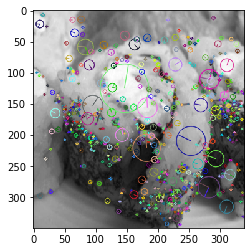

704x128


In [38]:

points = img = train_set[0][0]
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img,None)

points = cv2.drawKeypoints(img, keypoints, points, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(points) 
plt.show()  # display it
print(str(len(descriptors)) + "x" + str(len(descriptors[0])))

In [46]:
print(descriptors[0])
descs = descriptors[0]
for descriptor in descriptors[1:]:
    descs = np.vstack((descs, descriptor))

print(descs.shape)

[  4.   5.   3.  33.  55.   6.   1.   1. 158.  31.   5.  10.  11.   4.
   7.  90.  96.   3.   1.   0.   0.   2.   1.  86.   2.   1.   6.   2.
   1.   4.   3.   1.  11.   7.   2.  17. 158.  32.   0.   0. 158.  49.
   4.  12.  39.   0.   0.   1. 158.   9.   1.   0.   0.   1.   1.   3.
   0.   1.   5.   2.   1.   4.   3.   0.  14.   1.   0.   5. 158.  28.
   0.   2. 158.  35.   0.   4.  56.   9.   1.   6. 158.  31.   0.   0.
   0.   1.   0.   1.   0.   1.   1.   1.   2.   3.   0.   0.   3.   0.
   0.   1. 106.  61.   1.   2. 140.  57.   0.   0.  24.  42.   4.   7.
  50.  42.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
(704, 128)


In [79]:
classes = ['cactus', 'raccoon']
train_set, test_set = utils.load_data(classes)

Loaded 156 images for training and 40 images for testing. Categories: cactus, raccoon


In [80]:
descriptors = []
sift = cv2.SIFT_create()

for img, classid in train_set:
    key, desc = sift.detectAndCompute(img,None)
    descriptors.append((classid, desc))

print(len(descriptors))

156


In [81]:
descs = descriptors[0][1]

for classid, desc in descriptors[1:]:
    descs = np.vstack((descs, desc))

print(descs.shape)

(215072, 128)


In [82]:
k = len(classes) * 10
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=6)
kmeans.fit(descs)

print(len(kmeans.cluster_centers_))

/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=20. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=20. Setting it to 3*k
  cluster_centers = _init_centroids(
/home/juanolon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1572: RuntimeWarning: init_size=18 should be larger than k=20. Setting it to 3*k
  cluster_centers = _init_centroids(


20


In [83]:
histo_all = []
nkp = np.size(kp)
print("nkp", nkp)

for classid, desc in descriptors:
    histo = np.zeros(k)
    
    for d in desc:
        idx = kmeans.predict([d])
        # instead of increasing each bin by one, add the normalized value
        histo[idx] += 1/nkp

    histo_all.append(histo)

nkp 704


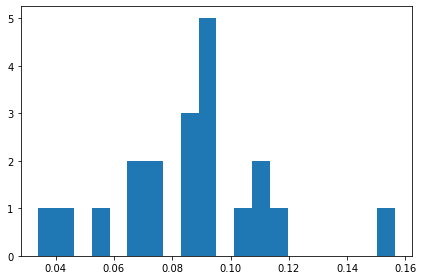

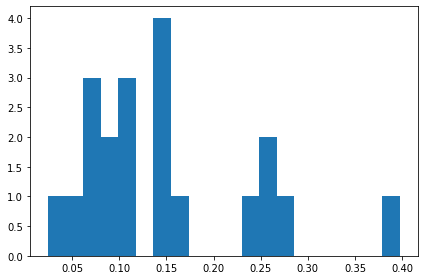

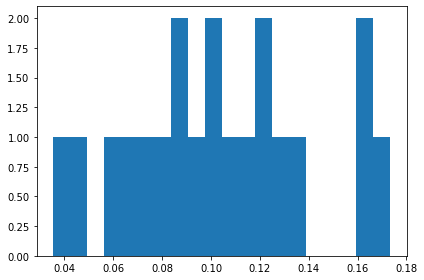

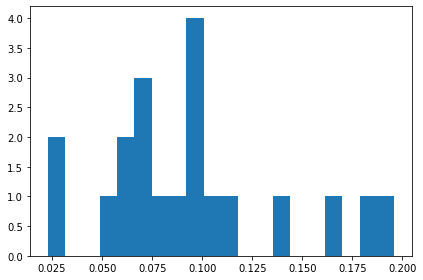

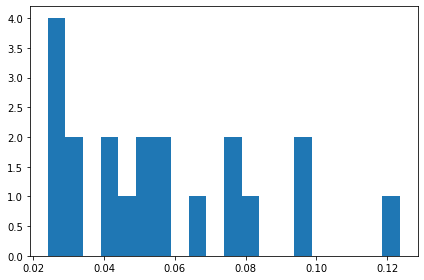

In [84]:
nbins = len(histo_all[i])
for i in range(5):
    fig, ax = plt.subplots(tight_layout=True)
    hist = ax.hist(histo_all[i], bins=nbins)

In [85]:
print(len(histo_all[0]))

20


In [86]:
X = np.array(histo_all)
Y = []

# encode classes
classes = ['cactus', 'dice', 'raccoon', 'spaghetti', 'sushi']
for classid, desc in descriptors:
    val = 0
    if classid == 'cactus':
        val = 0
    if classid == 'dice':
        val = 1
    if classid == 'raccoon':
        val = 2
    if classid == 'spaghetti':
        val = 3
    if classid == 'sushi':
        val = 4
    
    Y.append(val)

In [87]:
svm = LinearSVC()
svm.fit(X, Y)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [88]:
def getHistogram(img, cluster):
    # get features
    sift = cv2.SIFT_create()
    key, desc = sift.detectAndCompute(img,None)

    # create histogram
    histo = np.zeros(k)
    nkp = np.size(key)
    for d in desc:
        idx = cluster.predict([d])
        # instead of increasing each bin by one, add the normalized value
        histo[idx] += 1/nkp
        
    return histo

In [76]:
print(test_set[0])

for i in range(len(test_set)):
    hist = getHistogram(test_set[i][0], kmeans)
        
    classid = svm.predict([hist])
    print(test_set[i][1], classid)

(array([[190, 192, 195, ..., 223, 222, 221],
       [171, 174, 179, ..., 223, 222, 222],
       [126, 132, 141, ..., 224, 223, 223],
       ...,
       [ 76,  86, 101, ..., 244, 241, 239],
       [ 84,  94, 109, ..., 243, 239, 237],
       [ 88,  98, 113, ..., 242, 238, 236]], dtype=uint8), 'sushi')
sushi [4]
sushi [4]
sushi [4]
sushi [4]
sushi [1]
sushi [4]
sushi [4]
sushi [4]
sushi [4]
sushi [4]
sushi [4]
sushi [4]
sushi [1]
sushi [4]
sushi [4]
sushi [1]
sushi [1]
sushi [1]
sushi [4]
sushi [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [3]
raccoon [1]
raccoon [1]
raccoon [3]
raccoon [1]
raccoon [3]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [1]
raccoon [4]
raccoon [1]
dice [1]
dice [4]
dice [4]
dice [1]
dice [1]
dice [4]
dice [4]
dice [1]
dice [1]
dice [1]
dice [1]
dice [1]
dice [1]
dice [1]
dice [4]
dice [1]
dice [4]
dice [1]
dice [1]
dice [1]
cactus [1]
cactus [4]
cactus [1]
cactus [1]
cactus [0]
cactus [1]
cactus [1]
ca